In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import time
import os
from scipy.stats import wasserstein_distance
import pandas as pd
from sklearn.metrics import mean_absolute_error
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Mount google drive

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/praca_mgr'
os.chdir(path)

from utils import sum_channels_parallel_ as sum_channels_parallel

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load data

In [ ]:
# load dataset
from numpy import load

# load the dataset
data = load('./data/data_nonrandom_responses.npz')["arr_0"]
print('Loaded: ',  data.shape, "max:", data.max())

data_cond = load('./data/data_nonrandom_particles.npz')["arr_0"]
data_cond = pd.DataFrame(data_cond, columns =['Energy','Vx','Vy',	'Vz',	'Px',	'Py',	'Pz',	'mass',	'charge'])
COND_DIM=data_cond.shape[-1]
print('Loaded cond: ',  data_cond.shape)

Loaded:  (295867, 44, 44) max: 591.0
Loaded cond:  (295867, 9)


In [ ]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond = scaler.fit_transform(data_cond)
print("cond max", data_cond.max(), "min", data_cond.min())

data max 6.383507 min 0.0
cond max 10.15001 min -20.507631


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, data_cond, test_size=0.2, shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(236693, 44, 44) (59174, 44, 44) (236693, 9) (59174, 9)


In [ ]:
del data, data_cond

### Calculate channels for original simulation test data

In [ ]:
from utils import sum_channels_parallel_ as sum_channels_parallel
org=np.exp(x_test)-1
ch_org = np.array(org).reshape(-1,44,44)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values 
del org

### Define functions for making histograms

In [ ]:
def make_histograms(NAME, model, scale=1, noise_std=1):
  generator = tf.keras.models.load_model(model)
  calculate_ws_ch(generator,5, scale,  noise_std)

  z = np.random.normal(0,noise_std,(x_test.shape[0],10))
  z_c = y_test
  results = generator.predict([z,z_c])
  results = np.exp(results)-1
  results = results*scale

  ch_gen = np.array(results).reshape(-1,44,44)
  ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
  original=ch_org
  vae=ch_gen
  for i in range(0,5):
    bins = np.linspace(0, 1500, 250)
    plt.figure(figsize=(16,3))
    plt.yscale('log', nonposy='clip')
    plt.title(NAME+"\nKanał "+str(i+1))
    pyplot.hist(original[:,i], bins, alpha=0.5, label='true', color="red")
    pyplot.hist(vae[:,i], bins, alpha=0.5, label='generated', color="blue")
    pyplot.legend(loc='upper right')
    plt.ylabel('Liczba przykładów')
    plt.xlabel('Wartość kanału')
    pyplot.show()


In [ ]:
def calculate_ws_ch(generator, n_calc, scale=1, noise_std=1):

  ws= [0,0,0,0,0]
  for j in range(n_calc):
    z = np.random.normal(0,noise_std,(x_test.shape[0],10))
    z_c = y_test
    results = generator.predict([z,z_c])
    results = np.exp(results)-1
    results = results *scale

    ch_gen = np.array(results).reshape(-1,44,44)
    ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
    for i in range(5):
      ws[i] = ws[i] + wasserstein_distance(ch_org[:,i], ch_gen[:,i])
    ws =np.array(ws)

  ws = ws/n_calc
  print("\n","-"*30,"\n")
  print("ws mean",f'{ws.sum()/5:.2f}', end=" ")
  for n,score in enumerate(ws):
    print("ch"+str(n+1),f'{score:.2f}',end=" ")

### VAE


 ------------------------------ 

ws mean 6.38 ch1 4.57 ch2 5.21 ch3 4.17 ch4 4.35 ch5 13.58 

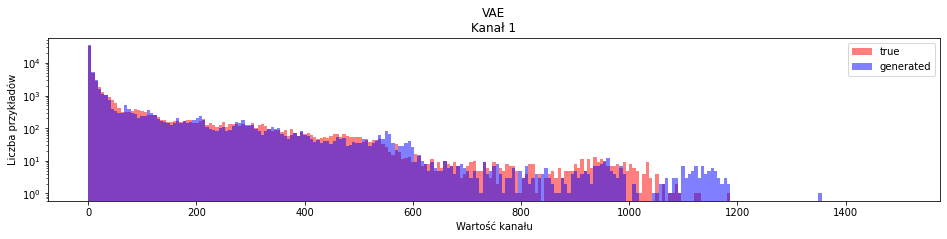

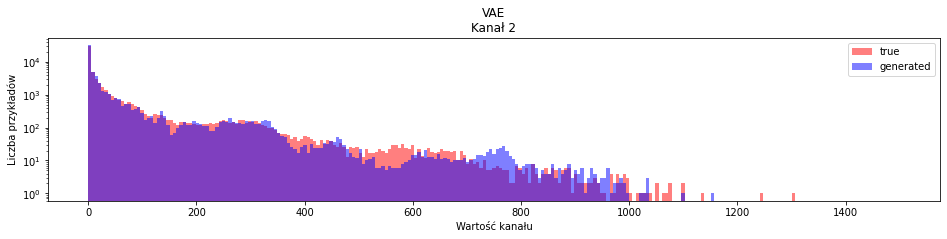

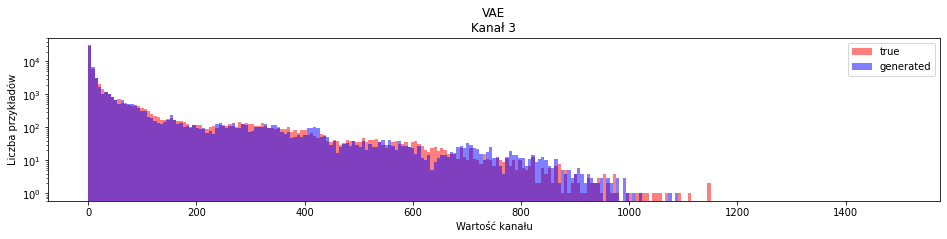

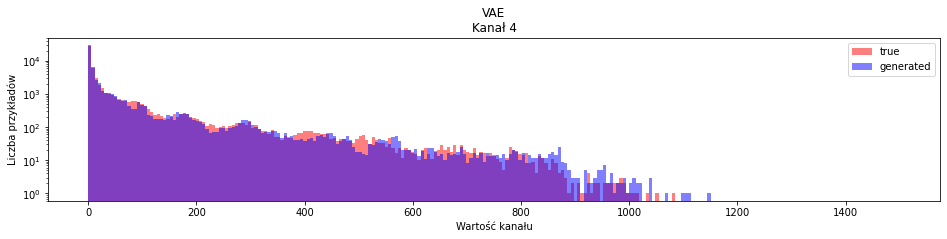

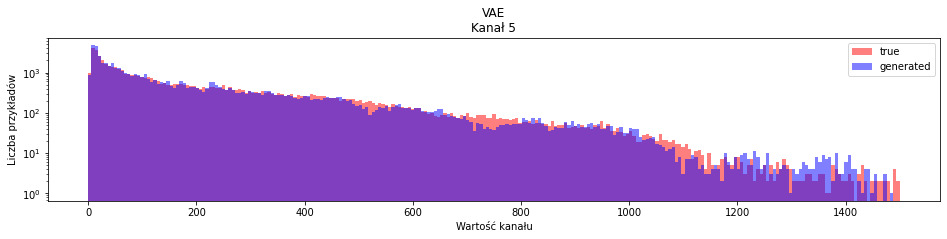

In [ ]:
make_histograms("VAE","./models/enerator_VAE.h5",1,1)

### GAN


 ------------------------------ 

ws mean 8.24 ch1 4.32 ch2 5.47 ch3 7.29 ch4 9.17 ch5 14.97 

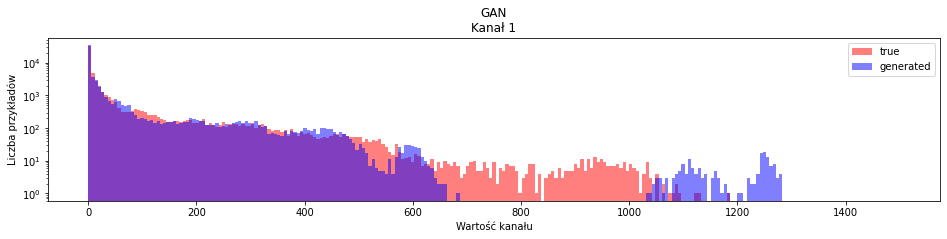

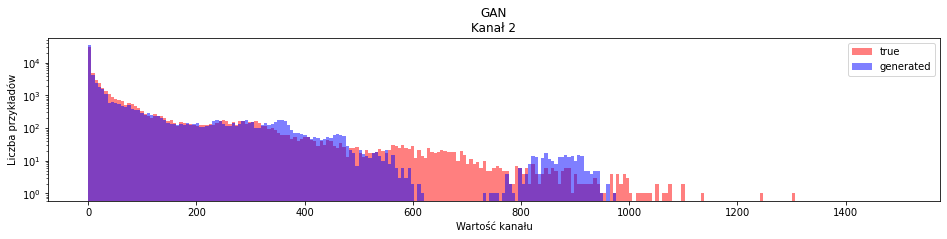

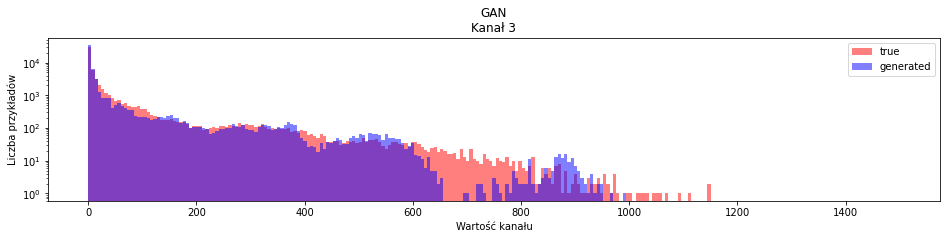

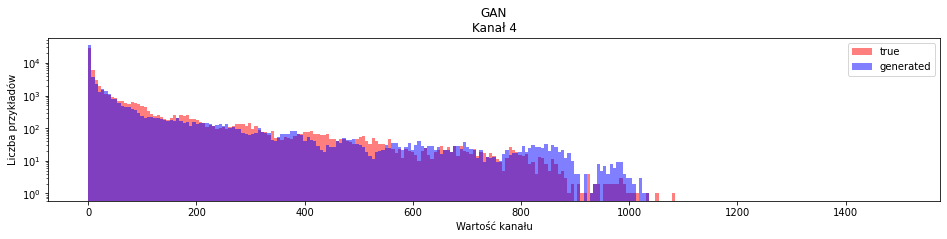

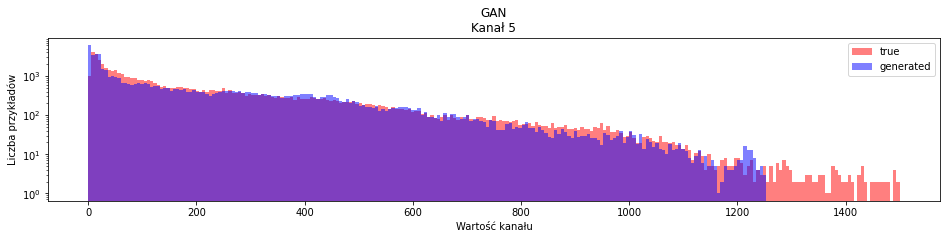

In [ ]:
make_histograms("GAN","./models/generator_GAN.h5",1,1)

### GAN with auxiliary regressor


 ------------------------------ 

ws mean 7.21 ch1 4.26 ch2 8.41 ch3 3.55 ch4 4.57 ch5 15.25 

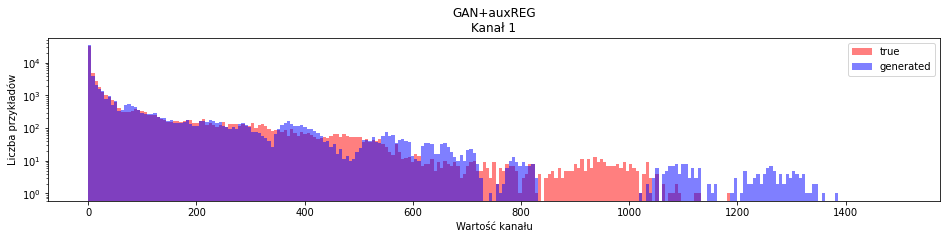

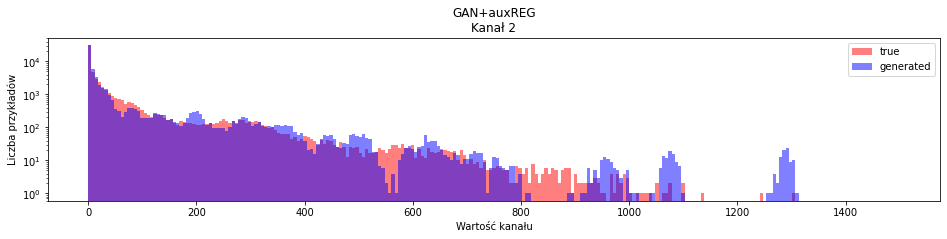

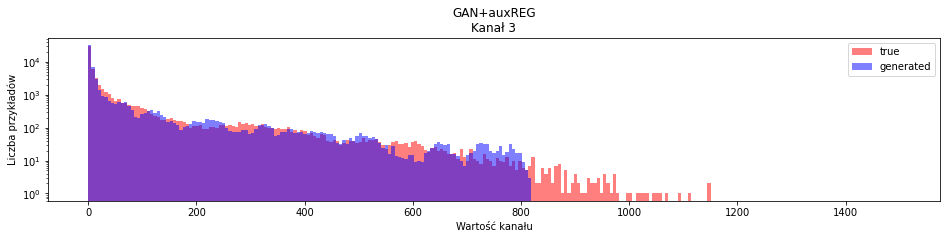

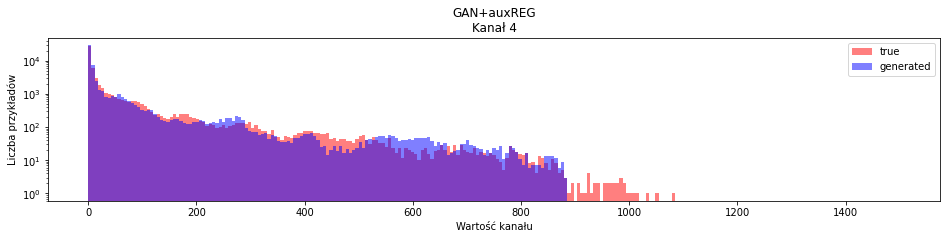

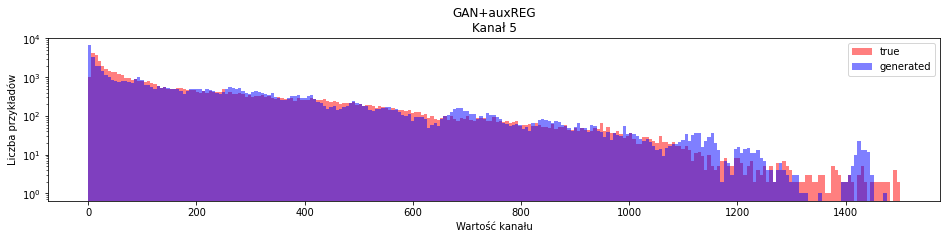

In [ ]:
make_histograms("GAN+auxREG","./models/generator_GAN_aux_reg.h5",1,1)

### GAN with postprocesssing


 ------------------------------ 

ws mean 5.74 ch1 2.46 ch2 3.98 ch3 3.68 ch4 5.98 ch5 12.60 

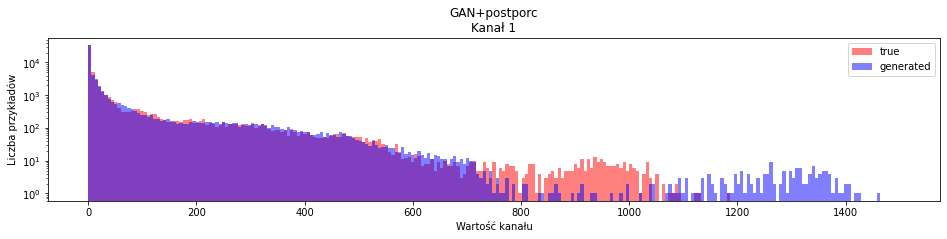

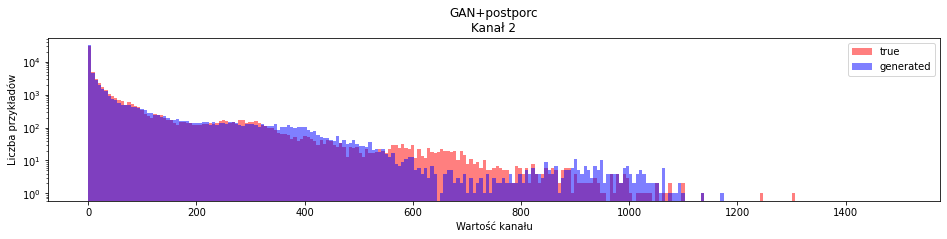

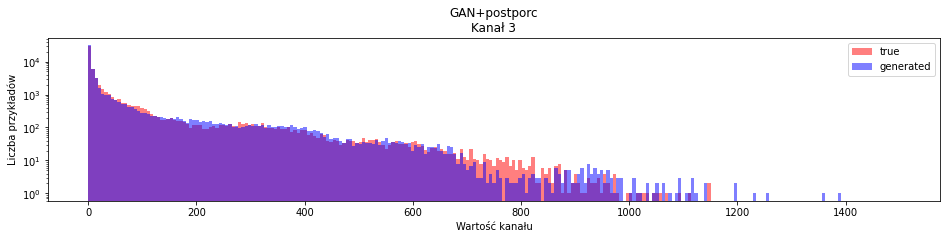

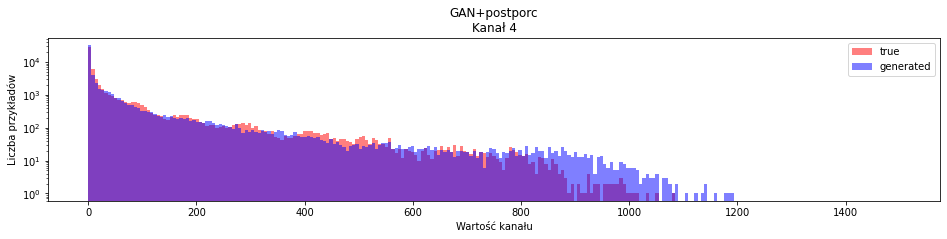

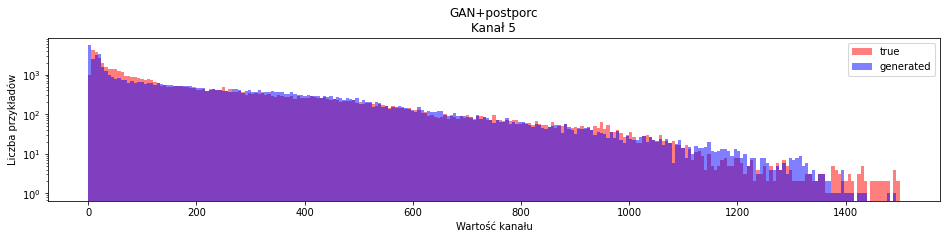

In [ ]:
make_histograms("GAN+postporc","./models/generator_GAN.h5",1.1,3)

### GAN with auxiliary regressor and postprocessing


 ------------------------------ 

ws mean 5.16 ch1 2.68 ch2 5.59 ch3 4.08 ch4 5.69 ch5 7.74 

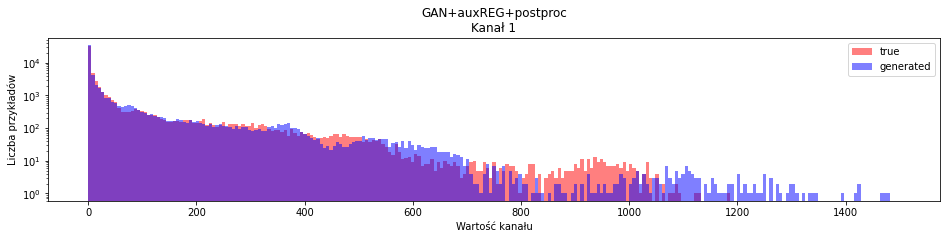

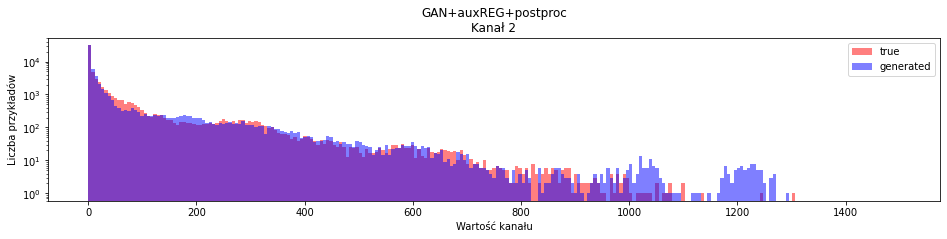

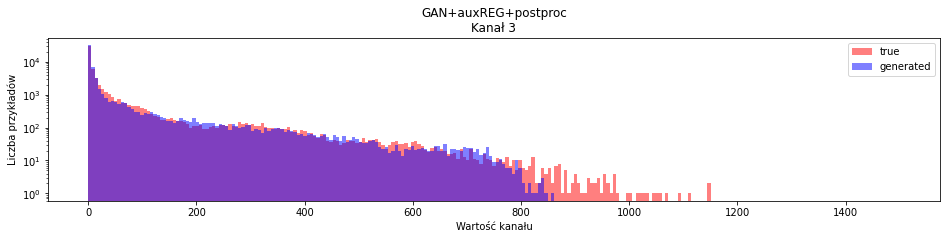

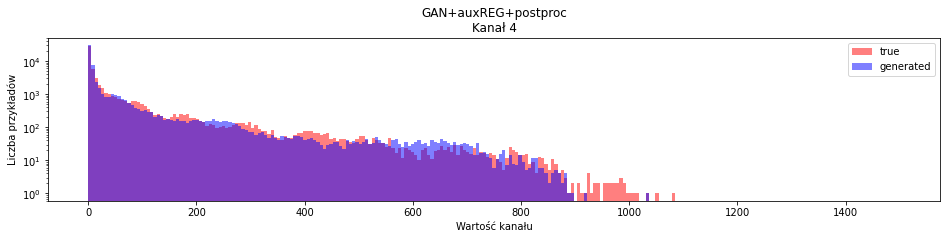

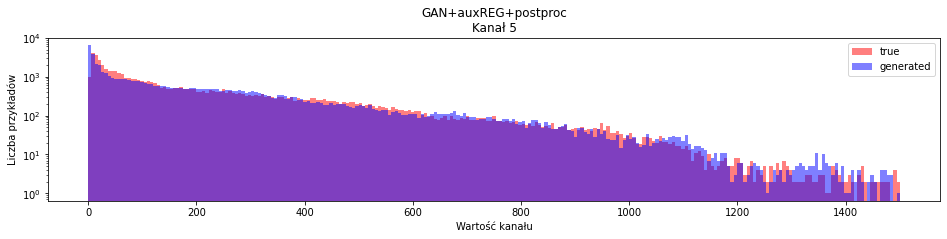

In [ ]:
make_histograms("GAN+auxREG+postproc","./models/generator_GAN_aux_reg.h5",0.96,3)